## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'batch0approx1e5-agriVision-wavelet-blue' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/wavelet/batch0approx1e5/blue'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:818: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:823: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:54<00:00, 1829.29it/s]


Layer 3


100%|██████████| 100000/100000 [00:57<00:00, 1742.86it/s]


Layer 4


100%|██████████| 100000/100000 [00:47<00:00, 2099.73it/s]


Layer 5


100%|██████████| 100000/100000 [00:48<00:00, 2079.92it/s]


Layer 6


100%|██████████| 100000/100000 [00:47<00:00, 2089.04it/s]


Layer 7


100%|██████████| 100000/100000 [00:47<00:00, 2092.23it/s]


Layer 8


100%|██████████| 100000/100000 [00:47<00:00, 2085.31it/s]


Layer 9


100%|██████████| 100000/100000 [00:48<00:00, 2080.88it/s]


Layer 10


100%|██████████| 100000/100000 [00:48<00:00, 2063.87it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0


## Initial Grid Search and Hypothesis Test Plots

####
Layer  2


100%|██████████| 52429/52429 [00:19<00:00, 2710.47it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 9000, Without approximation : 9000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


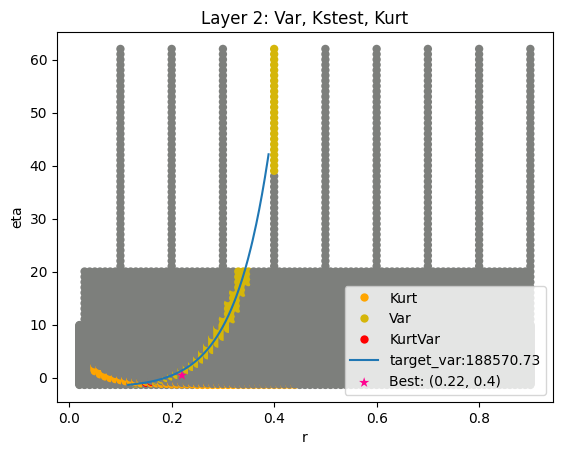

####
Layer  3


100%|██████████| 52429/52429 [01:02<00:00, 832.54it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 36000, Without approximation : 36000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


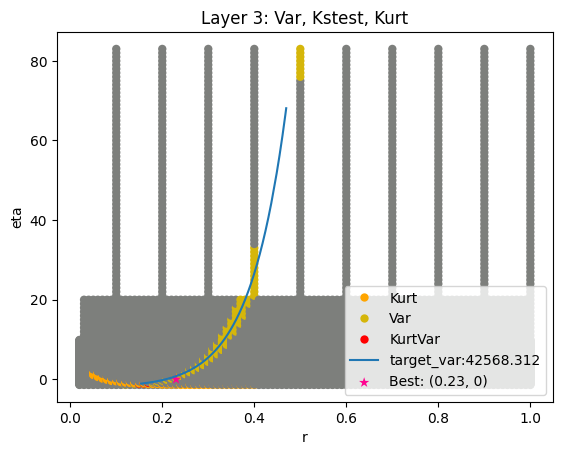

####
Layer  4


100%|██████████| 52429/52429 [02:51<00:00, 305.14it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 144000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


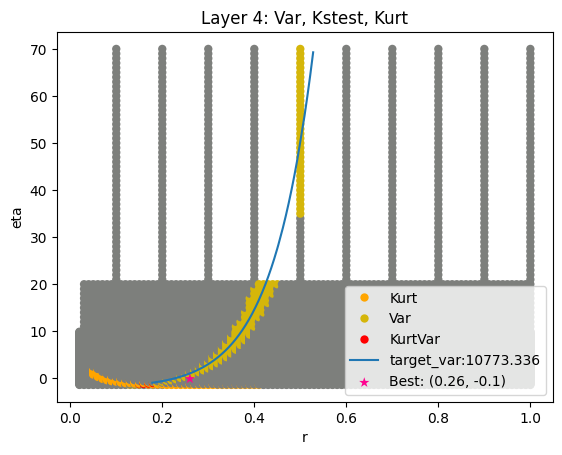

####
Layer  5


100%|██████████| 52429/52429 [02:51<00:00, 305.13it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 576000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


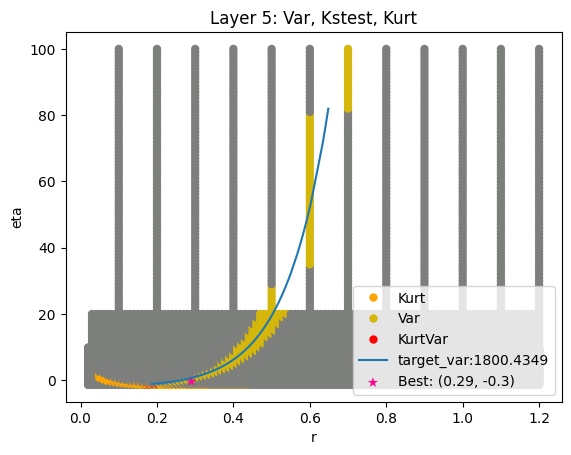

####
Layer  6


100%|██████████| 52429/52429 [02:51<00:00, 305.91it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 2304000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


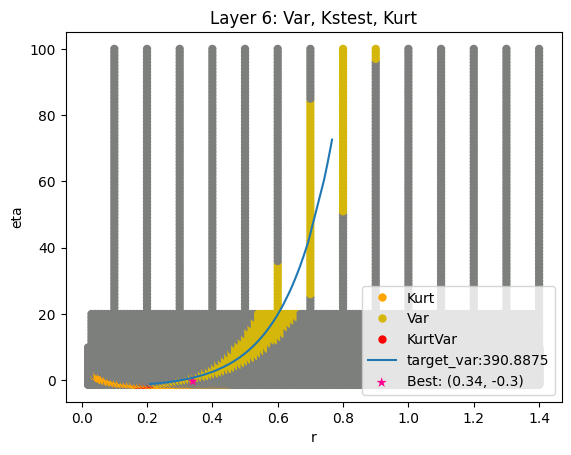

####
Layer  7


100%|██████████| 52429/52429 [02:51<00:00, 306.57it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 9216000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


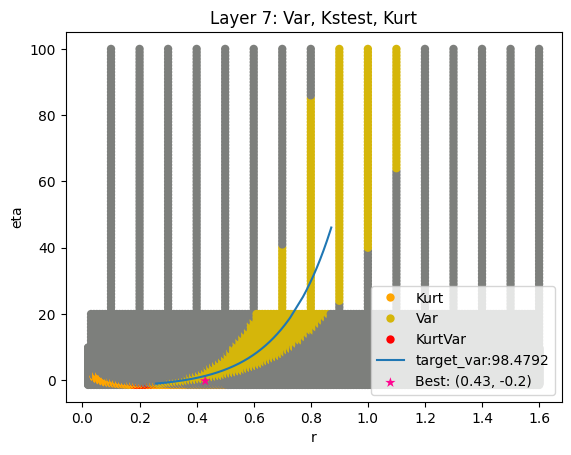

####
Layer  8


100%|██████████| 52429/52429 [02:51<00:00, 306.28it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 36864000.0


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


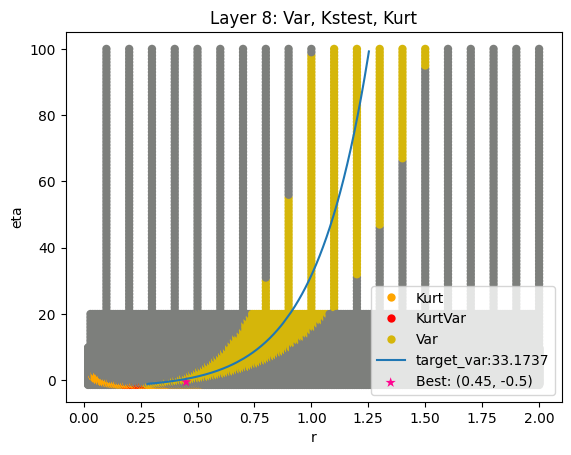

####
Layer  9


100%|██████████| 52429/52429 [02:51<00:00, 306.27it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 147456000.0


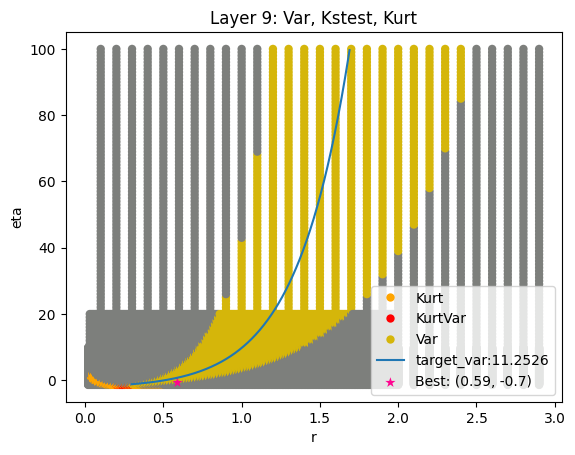

####
Layer  10


100%|██████████| 52429/52429 [02:57<00:00, 295.44it/s]


Finding Minimum after computing 52429 CDFs
Number of samples: 100000, Without approximation : 589824000.0


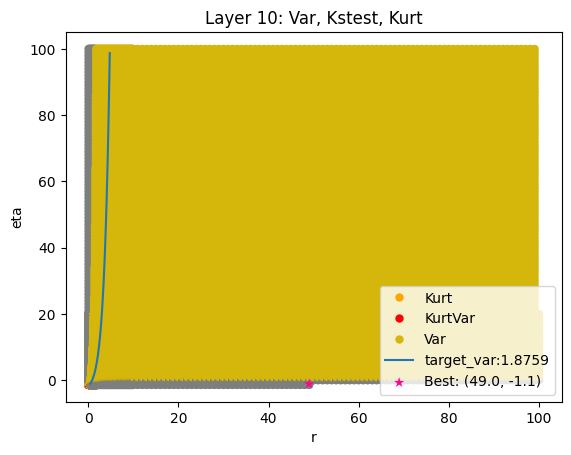

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0,0.22,0.4,0.017674,0.014297
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0,0.23,0.0,0.016221,0.007153
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0,0.26,-0.1,0.013363,0.003578
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0,0.29,-0.3,0.010661,0.001789
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0,0.34,-0.3,0.006480,0.000895
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0,0.43,-0.2,0.006646,0.000447
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0,0.45,-0.5,0.005162,0.000224
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0,0.59,-0.7,0.006635,0.000112
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0,49.00,-1.1,0.029237,0.000056


In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
            best_params_eta0.append(best_param_eta0[0])
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            best_params_eta0.append(master_df.loc[group, 'initial_r'])
    master_df['best_r_eta0'] = best_params_eta0
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 2657.01it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 293.30it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 264.46it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 300.09it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 274.41it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 281.05it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 305.91it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 302.52it/s]


Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0,0.22,0.4,0.017674,0.014297,0.025901,0.20
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0,0.23,0.0,0.016221,0.007153,0.016221,0.23
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0,0.26,-0.1,0.013363,0.003578,0.018498,0.27
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0,0.29,-0.3,0.010661,0.001789,0.017831,0.32
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0,0.34,-0.3,0.006480,0.000895,0.012899,0.38
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0,0.43,-0.2,0.006646,0.000447,0.010884,0.46
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0,0.45,-0.5,0.005162,0.000224,0.015243,0.57
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0,0.59,-0.7,0.006635,0.000112,0.025605,1.04
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0,49.00,-1.1,0.029237,0.000056,0.145496,6.20


## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2


100%|██████████| 420/420 [00:00<00:00, 2974.74it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 2 best parameters: ((0.216, 0.31), 0.014511614144503526)


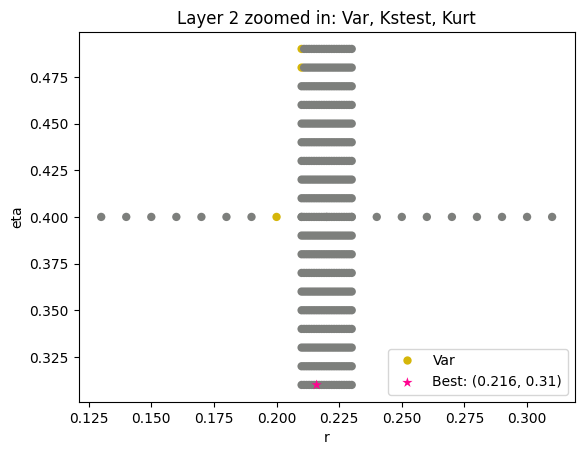

Layer 3
(0.222, -0.01), 50 of 420
(0.224, 0.09), 100 of 420
(0.227, -0.01), 150 of 420
(0.229, 0.09), 200 of 420
(0.232, -0.01), 250 of 420
(0.234, 0.09), 300 of 420
(0.237, -0.01), 350 of 420
(0.239, 0.09), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 780.86it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 3 best parameters: ((0.232, 0.02), 0.013929526007962045)


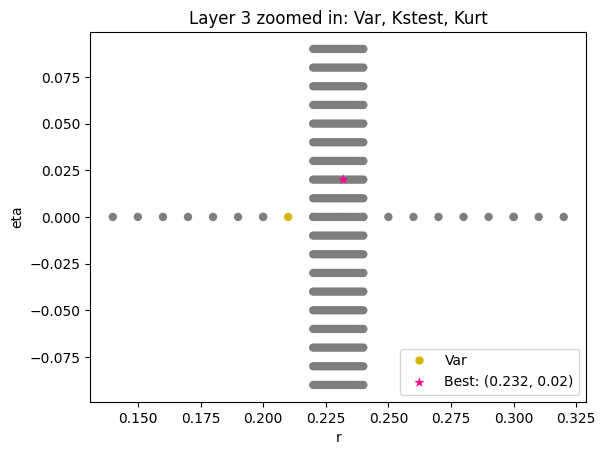

Layer 4
(0.252, -0.11), 50 of 420
(0.254, -0.01), 100 of 420
(0.257, -0.11), 150 of 420
(0.259, -0.01), 200 of 420
(0.262, -0.11), 250 of 420
(0.264, -0.01), 300 of 420
(0.267, -0.11), 350 of 420
(0.269, -0.01), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 283.17it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 4 best parameters: ((0.253, -0.2), 0.011648252327939201)


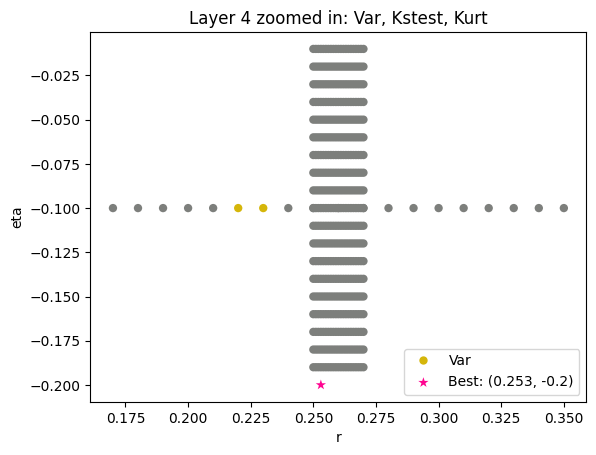

Layer 5
(0.282, -0.33), 50 of 441
(0.284, -0.25), 100 of 441
(0.287, -0.38), 150 of 441
(0.289, -0.3), 200 of 441
(0.291, -0.22), 250 of 441
(0.294, -0.35), 300 of 441
(0.296, -0.27), 350 of 441
(0.299, -0.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 288.86it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((0.282, -0.36), 0.008582831309285721)


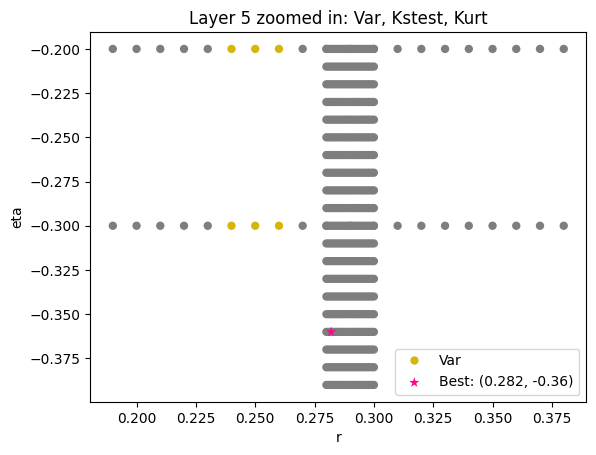

Layer 6
(0.332, -0.33), 50 of 441
(0.334, -0.25), 100 of 441
(0.337, -0.38), 150 of 441
(0.339, -0.3), 200 of 441
(0.341, -0.22), 250 of 441
(0.344, -0.35), 300 of 441
(0.346, -0.27), 350 of 441
(0.349, -0.4), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 287.21it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 6 best parameters: ((0.336, -0.33), 0.006308535748963479)


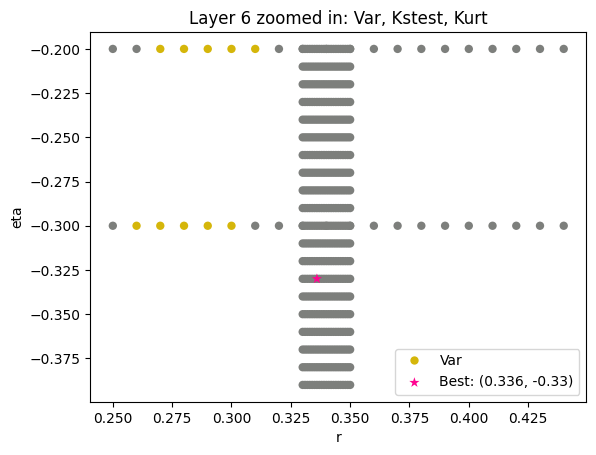

Layer 7
(0.422, -0.23), 50 of 441
(0.424, -0.15), 100 of 441
(0.427, -0.28), 150 of 441
(0.429, -0.2), 200 of 441
(0.431, -0.12), 250 of 441
(0.434, -0.25), 300 of 441
(0.436, -0.17), 350 of 441
(0.439, -0.3), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 291.64it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 7 best parameters: ((0.421, -0.25), 0.005785653486290565)


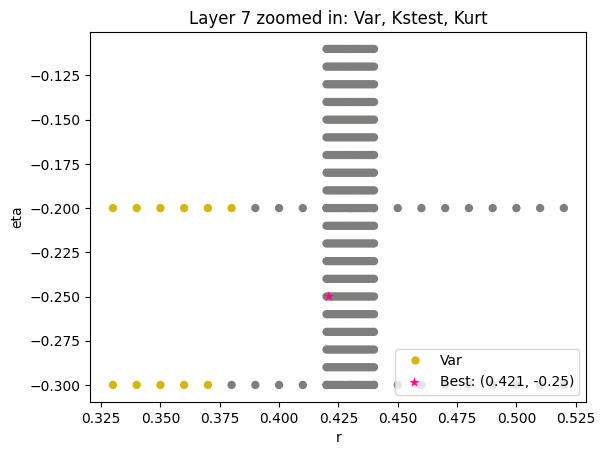

Layer 8
(0.442, -0.51), 50 of 420
(0.444, -0.41), 100 of 420
(0.447, -0.51), 150 of 420
(0.449, -0.41), 200 of 420
(0.452, -0.51), 250 of 420
(0.454, -0.41), 300 of 420
(0.457, -0.51), 350 of 420
(0.459, -0.41), 400 of 420


100%|██████████| 420/420 [00:02<00:00, 196.04it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 8 best parameters: ((0.455, -0.48), 0.004101371684367305)


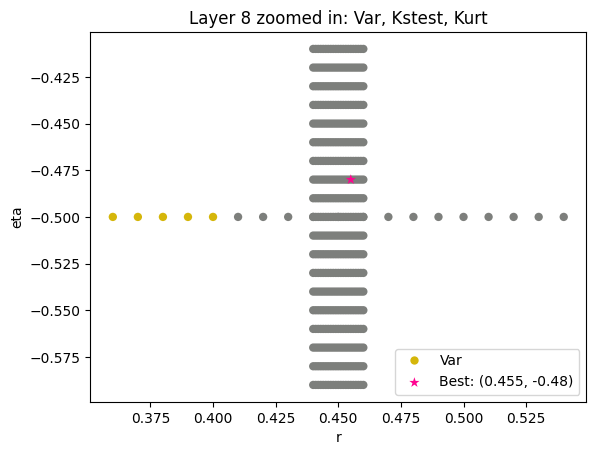

Layer 9
(0.582, -0.71), 50 of 420
(0.584, -0.61), 100 of 420
(0.587, -0.71), 150 of 420
(0.589, -0.61), 200 of 420
(0.592, -0.71), 250 of 420
(0.594, -0.61), 300 of 420
(0.597, -0.71), 350 of 420
(0.599, -0.61), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 300.56it/s]
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 420 CDFs
Iter 1 layer 9 best parameters: ((0.591, -0.7), 0.0065481490751753135)


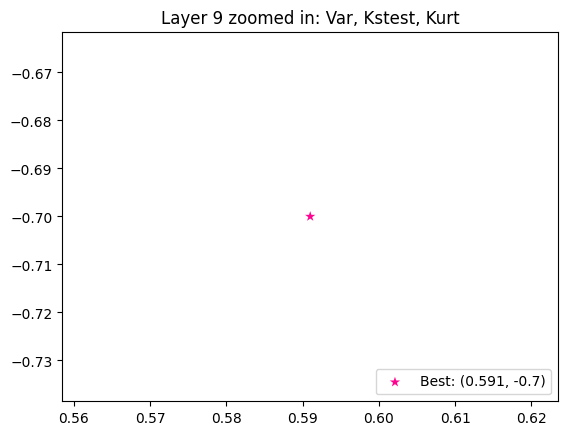

Layer 10
(41.0, -1.13), 50 of 420
(43.0, -1.05), 100 of 420
(46.0, -1.18), 150 of 420
(48.0, -1.1), 200 of 420
(50.0, -1.02), 250 of 420
(53.0, -1.15), 300 of 420
(55.0, -1.07), 350 of 420
(58.0, -1.2), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 288.94it/s]
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 420 CDFs
Iter 1 layer 10 best parameters: ((41.0, -1.08), 0.026099999999973478)


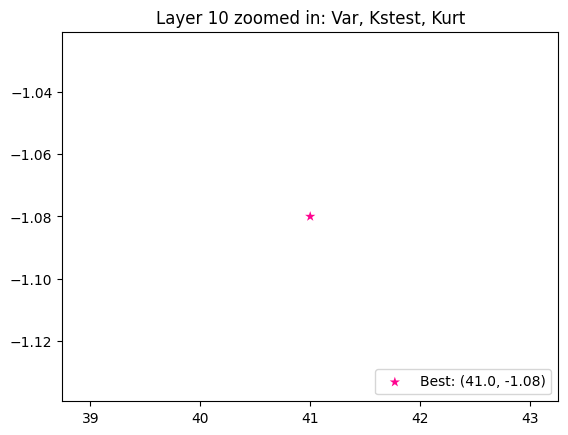

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0,0.22,0.4,0.017674,0.014297,0.025901,0.20,0.216,0.31,0.014512,0.216,0.31,0.014512,9000.0
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0,0.23,0.0,0.016221,0.007153,0.016221,0.23,0.232,0.02,0.013930,0.232,0.02,0.013930,9607.0
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0,0.26,-0.1,0.013363,0.003578,0.018498,0.27,0.253,-0.20,0.011648,0.253,-0.20,0.011648,13500.0
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0,0.29,-0.3,0.010661,0.001789,0.017831,0.32,0.282,-0.36,0.008583,0.282,-0.36,0.008583,25627.0
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0,0.34,-0.3,0.006480,0.000895,0.012899,0.38,0.336,-0.33,0.006309,0.336,-0.33,0.006309,45562.0
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0,0.43,-0.2,0.006646,0.000447,0.010884,0.46,0.421,-0.25,0.005786,0.421,-0.25,0.005786,54000.0
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0,0.45,-0.5,0.005162,0.000224,0.015243,0.57,0.455,-0.48,0.004101,0.455,-0.48,0.004101,108000.0
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0,0.59,-0.7,0.006635,0.000112,0.025605,1.04,0.591,-0.70,0.006548,0.591,-0.70,0.006548,45562.0
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0,49.00,-1.1,0.029237,0.000056,0.145496,6.20,41.000,-1.08,0.026100,41.000,-1.08,0.026100,2845.0


In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

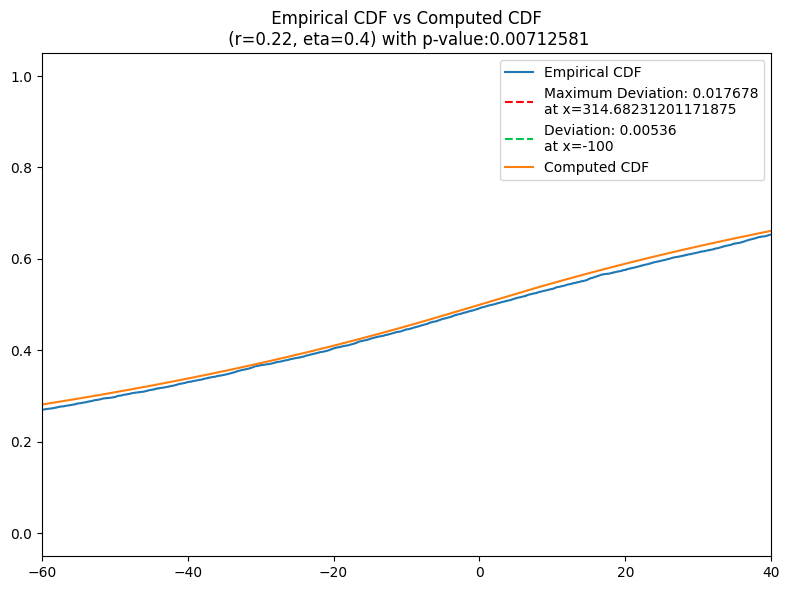

In [12]:
# Example Cell
group = 2
visualize_cdf(sample = group_data_map[group], 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

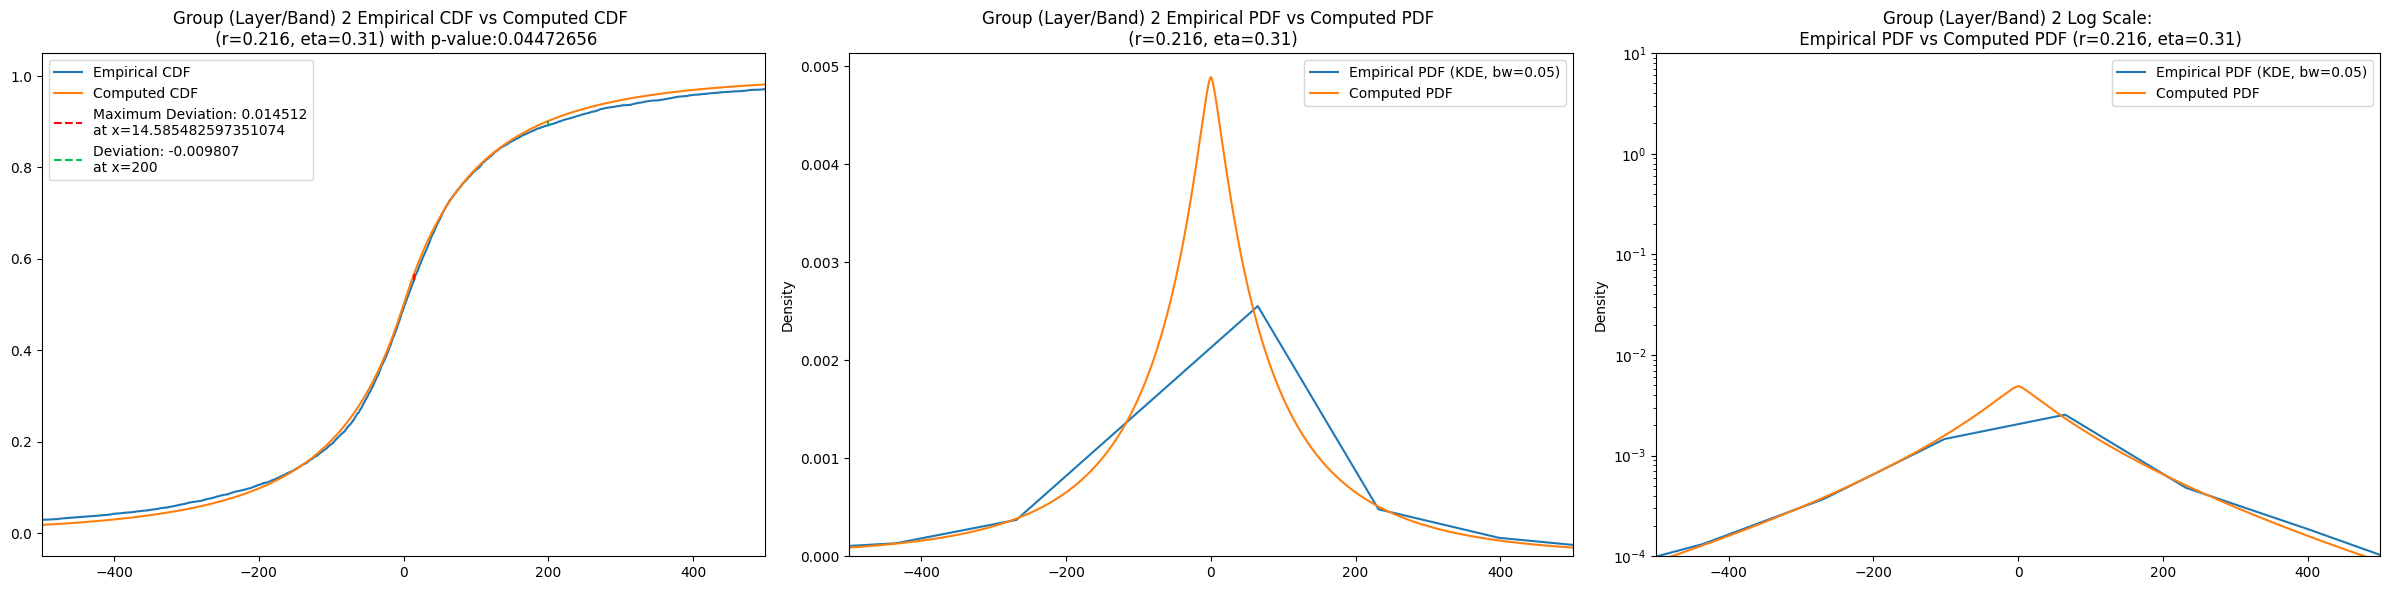

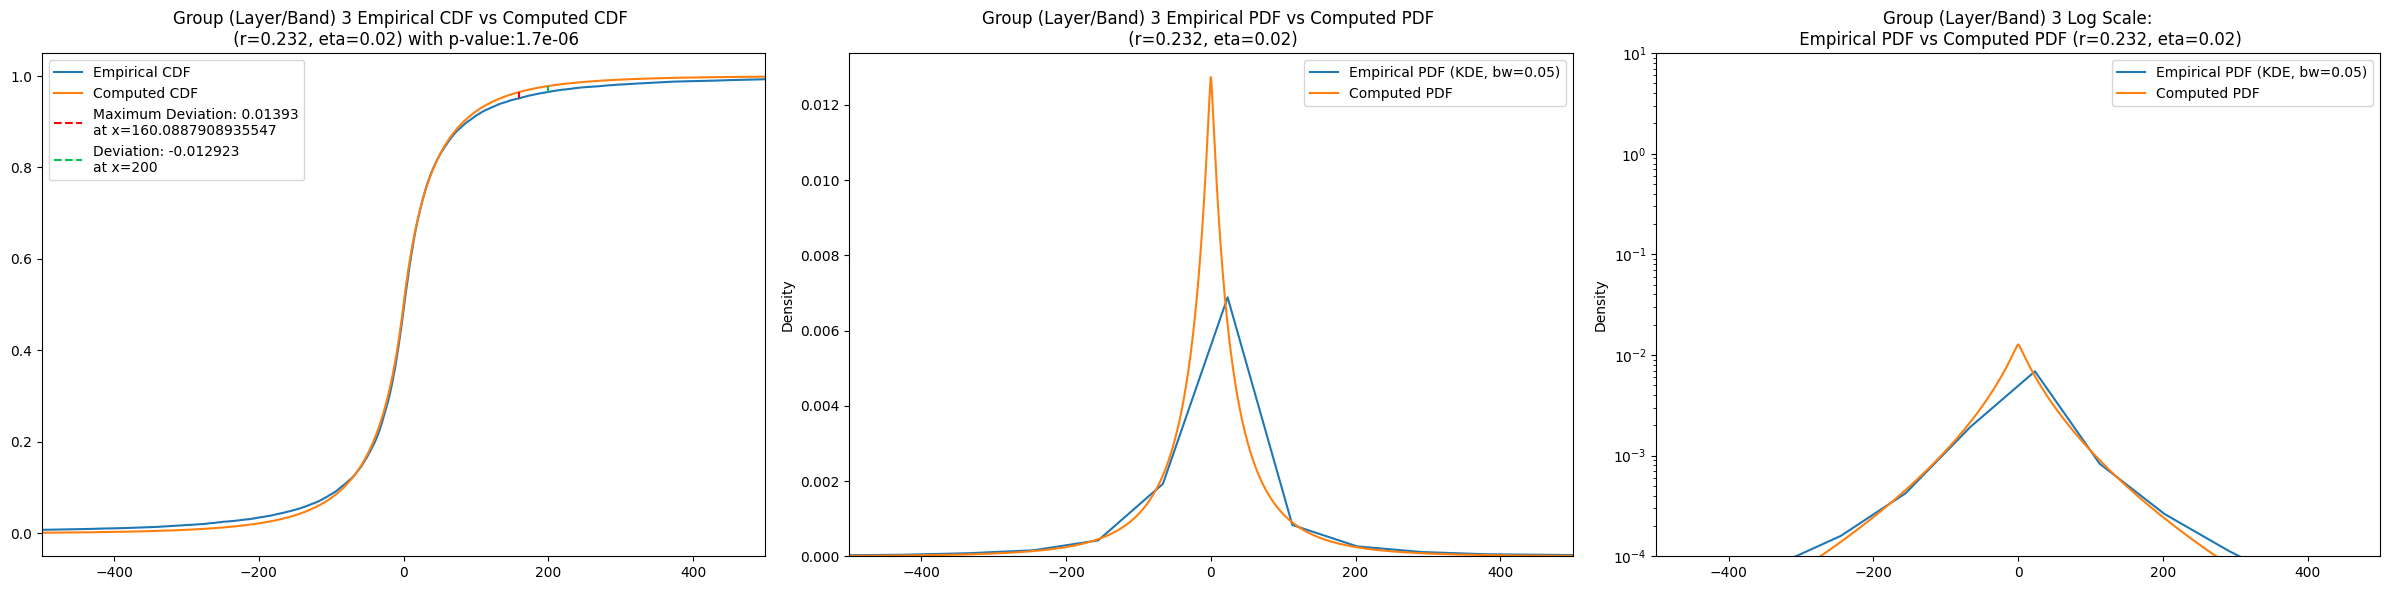

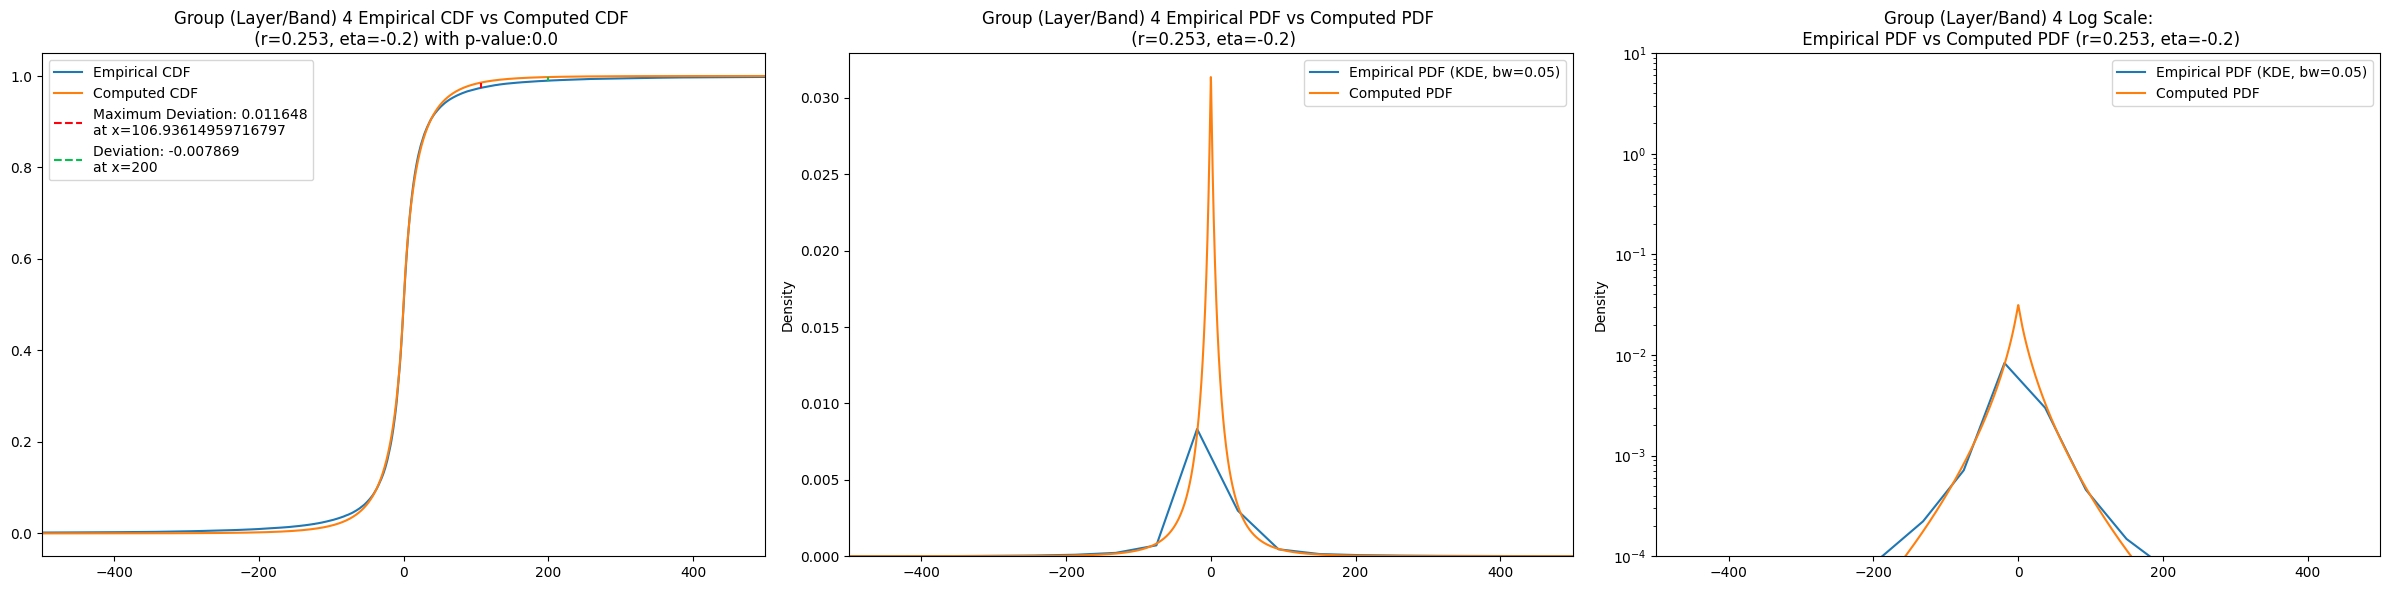

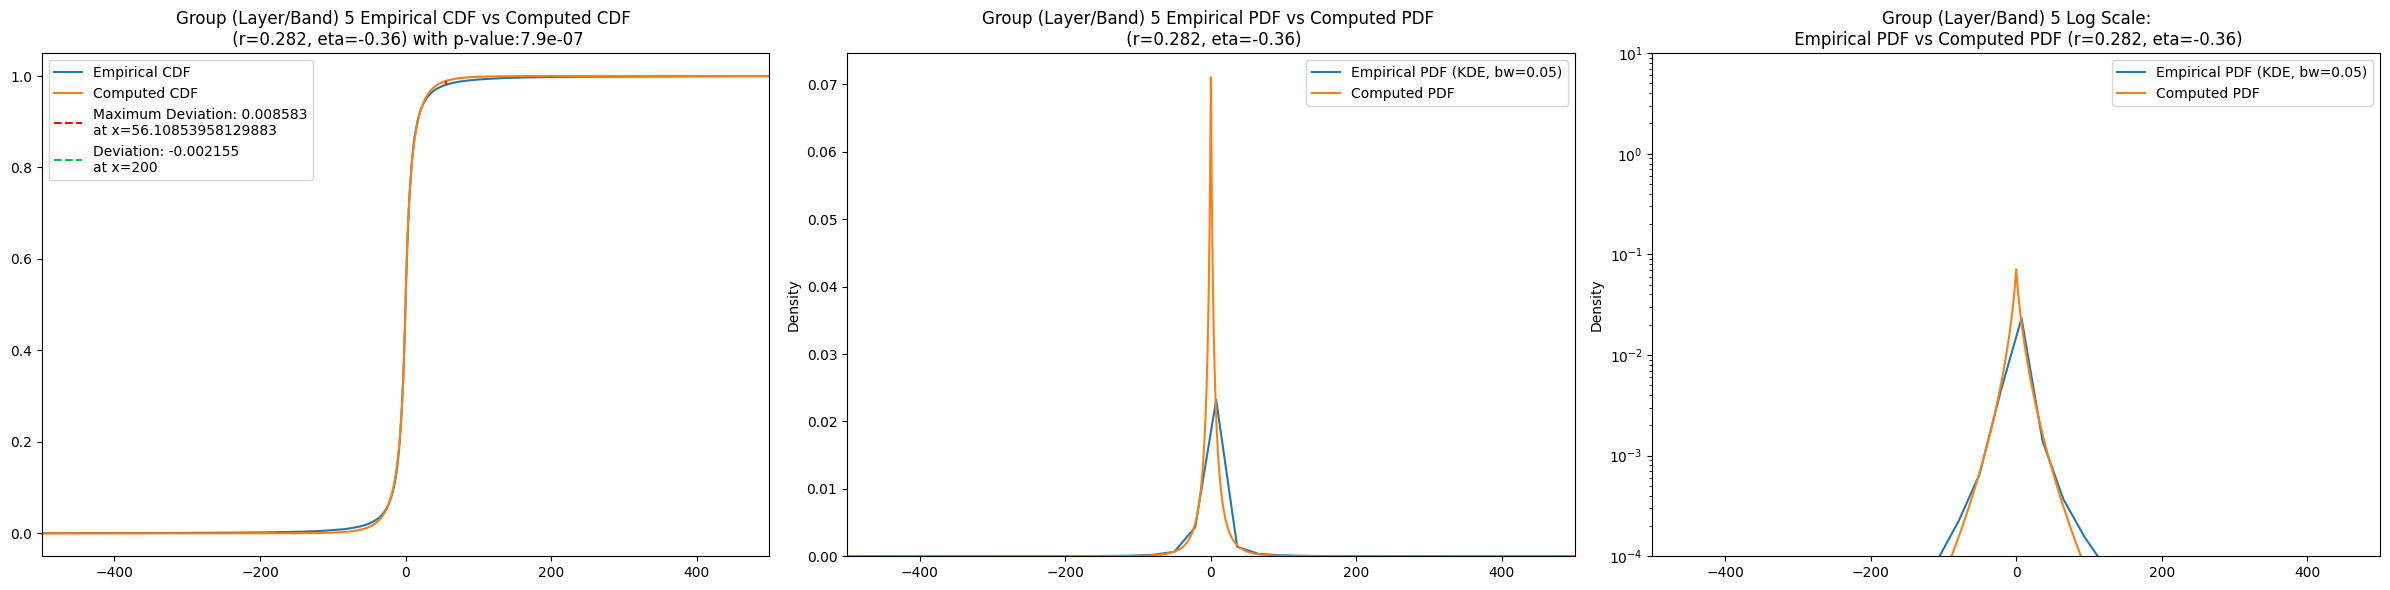

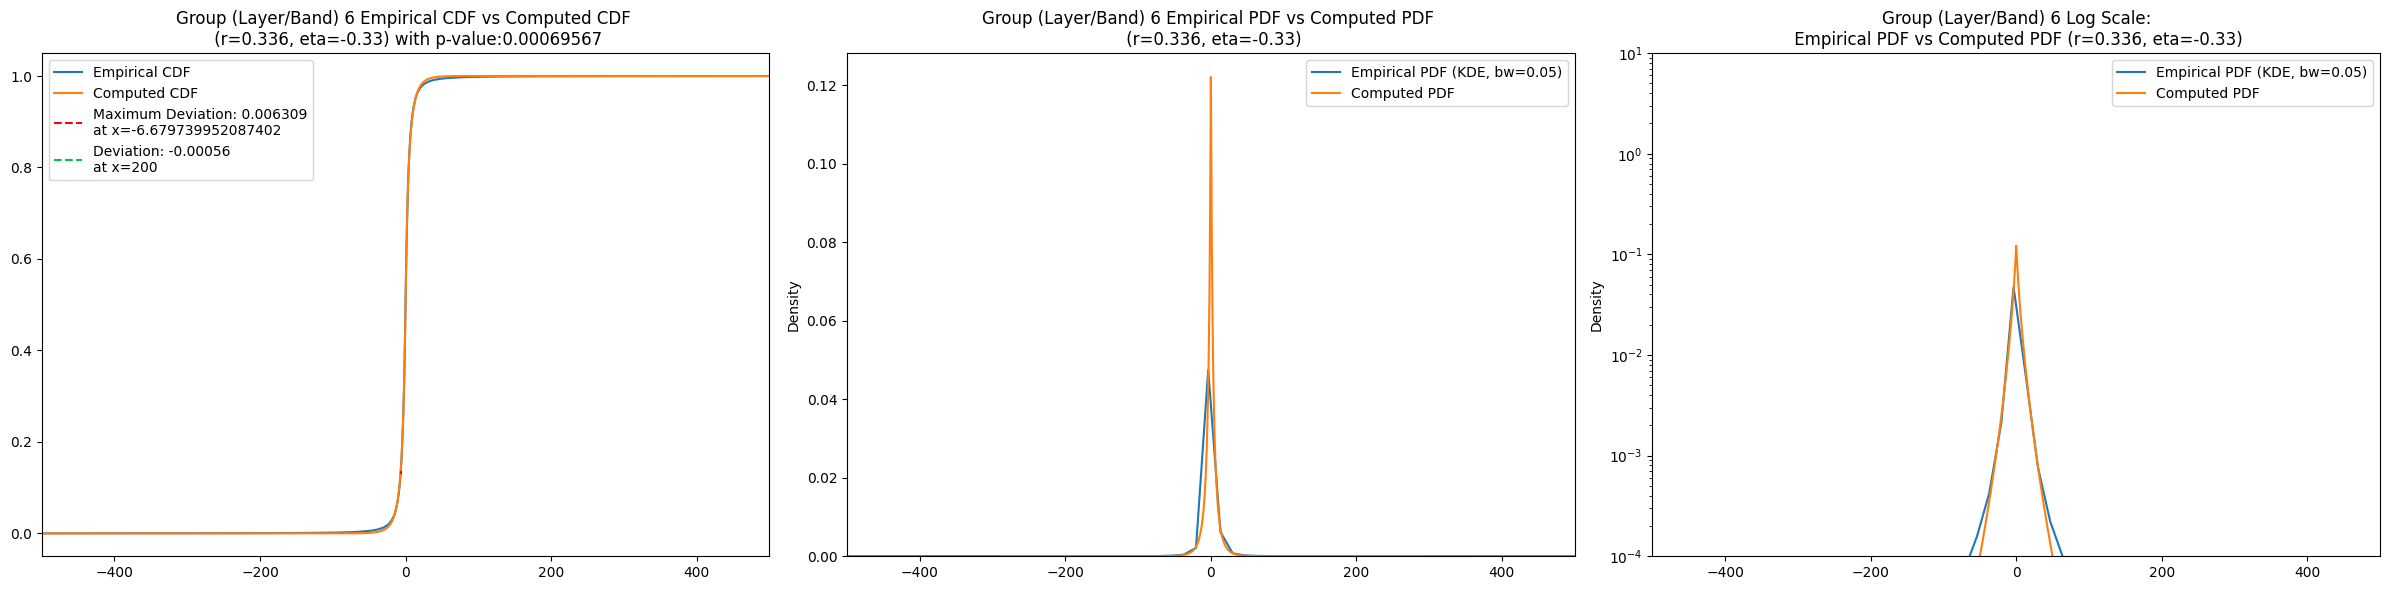

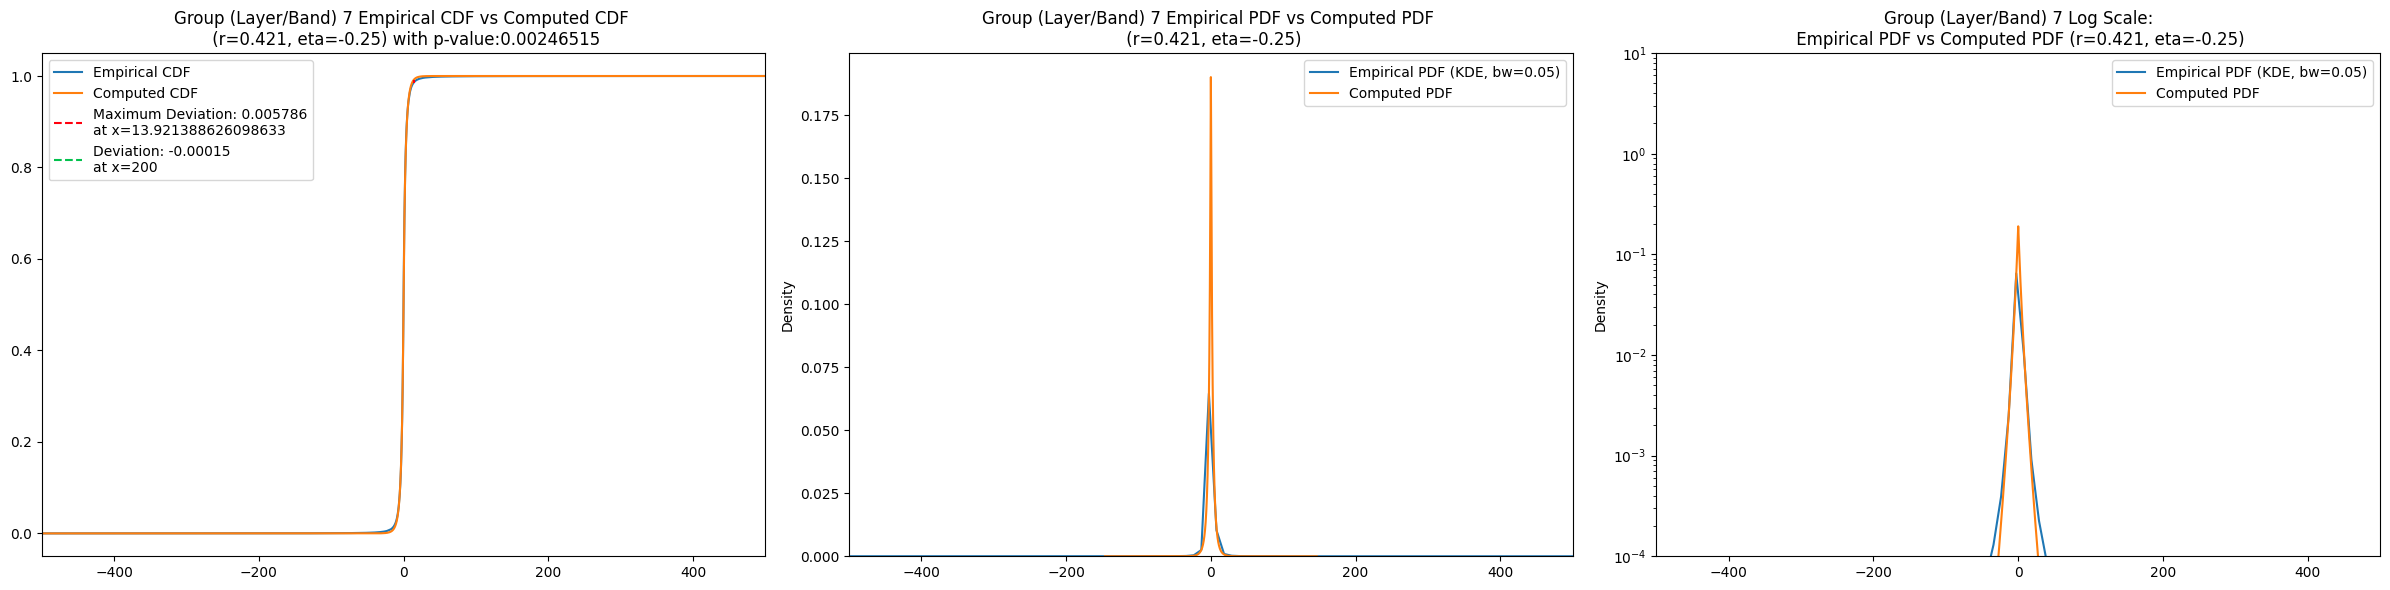

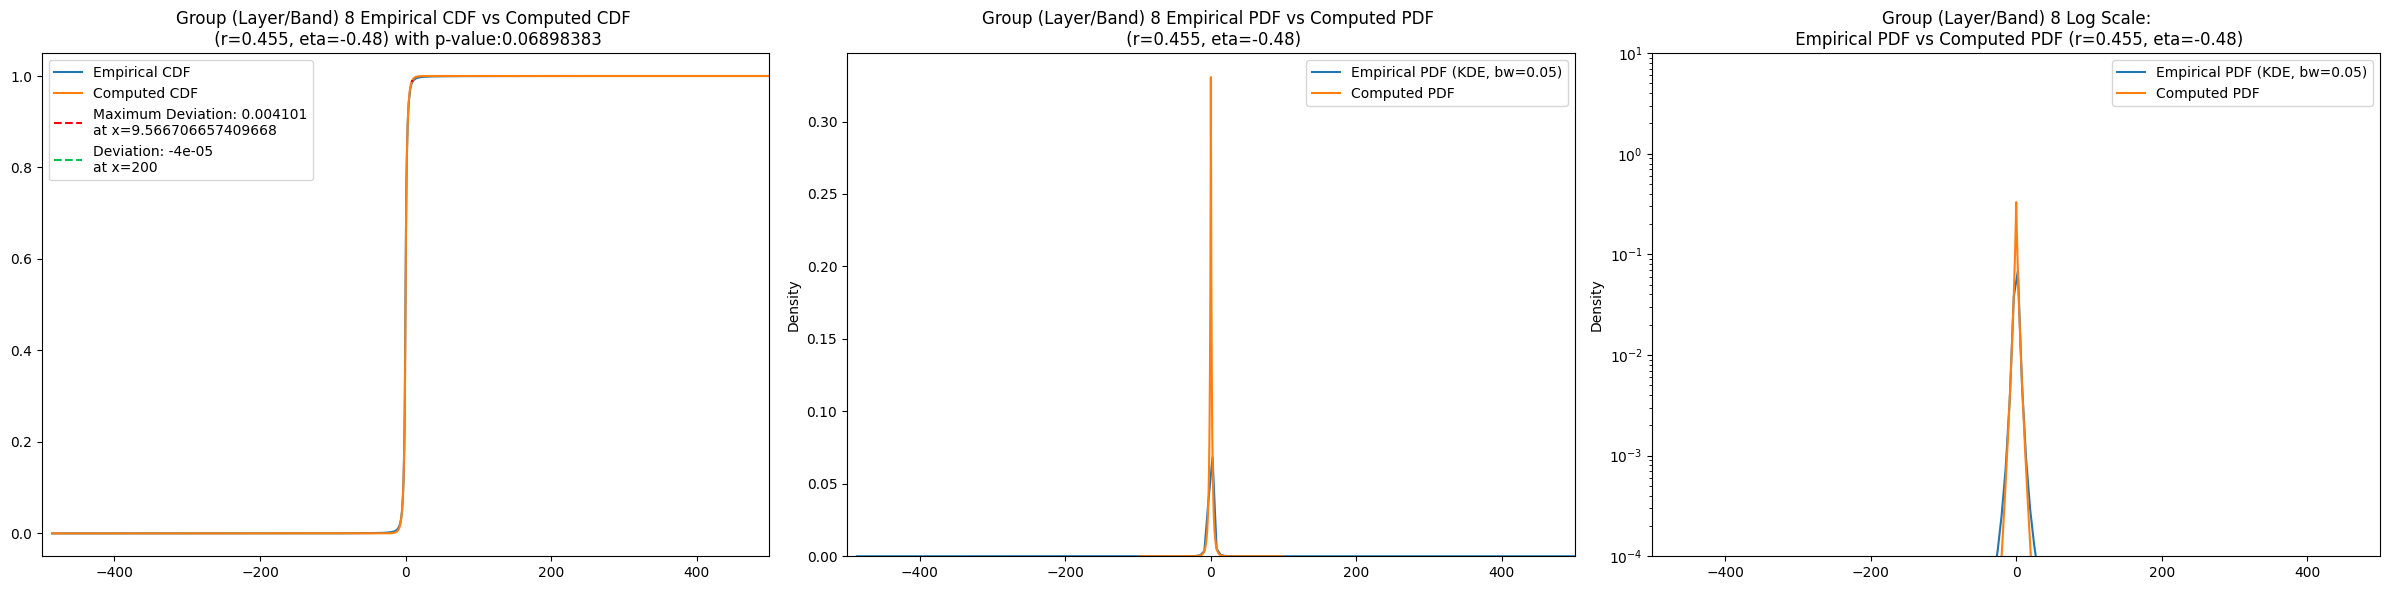

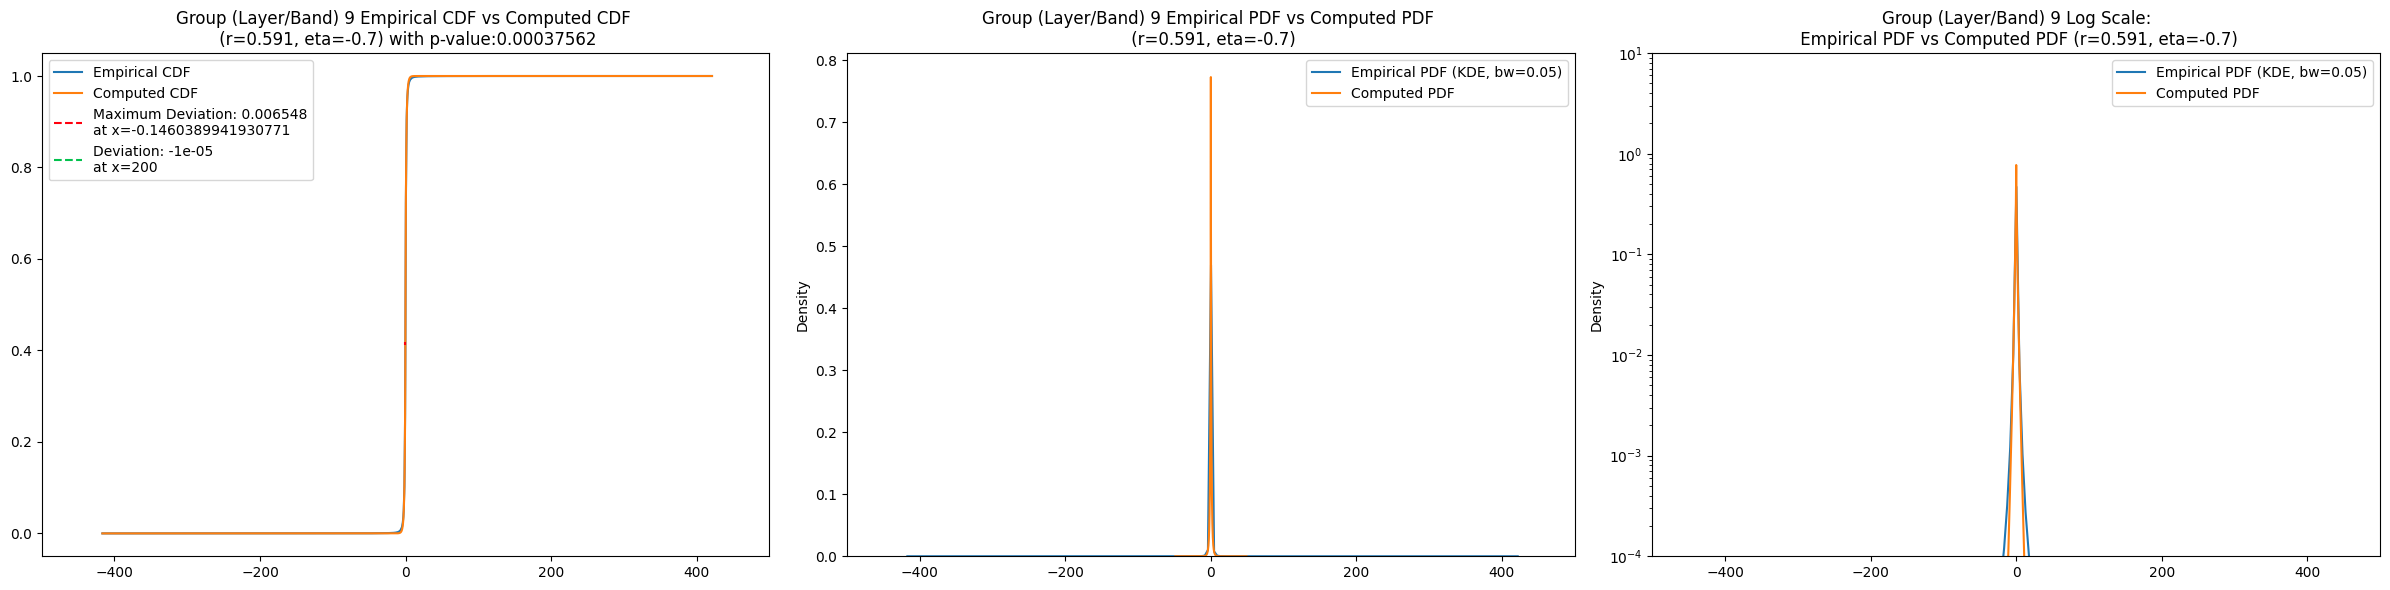

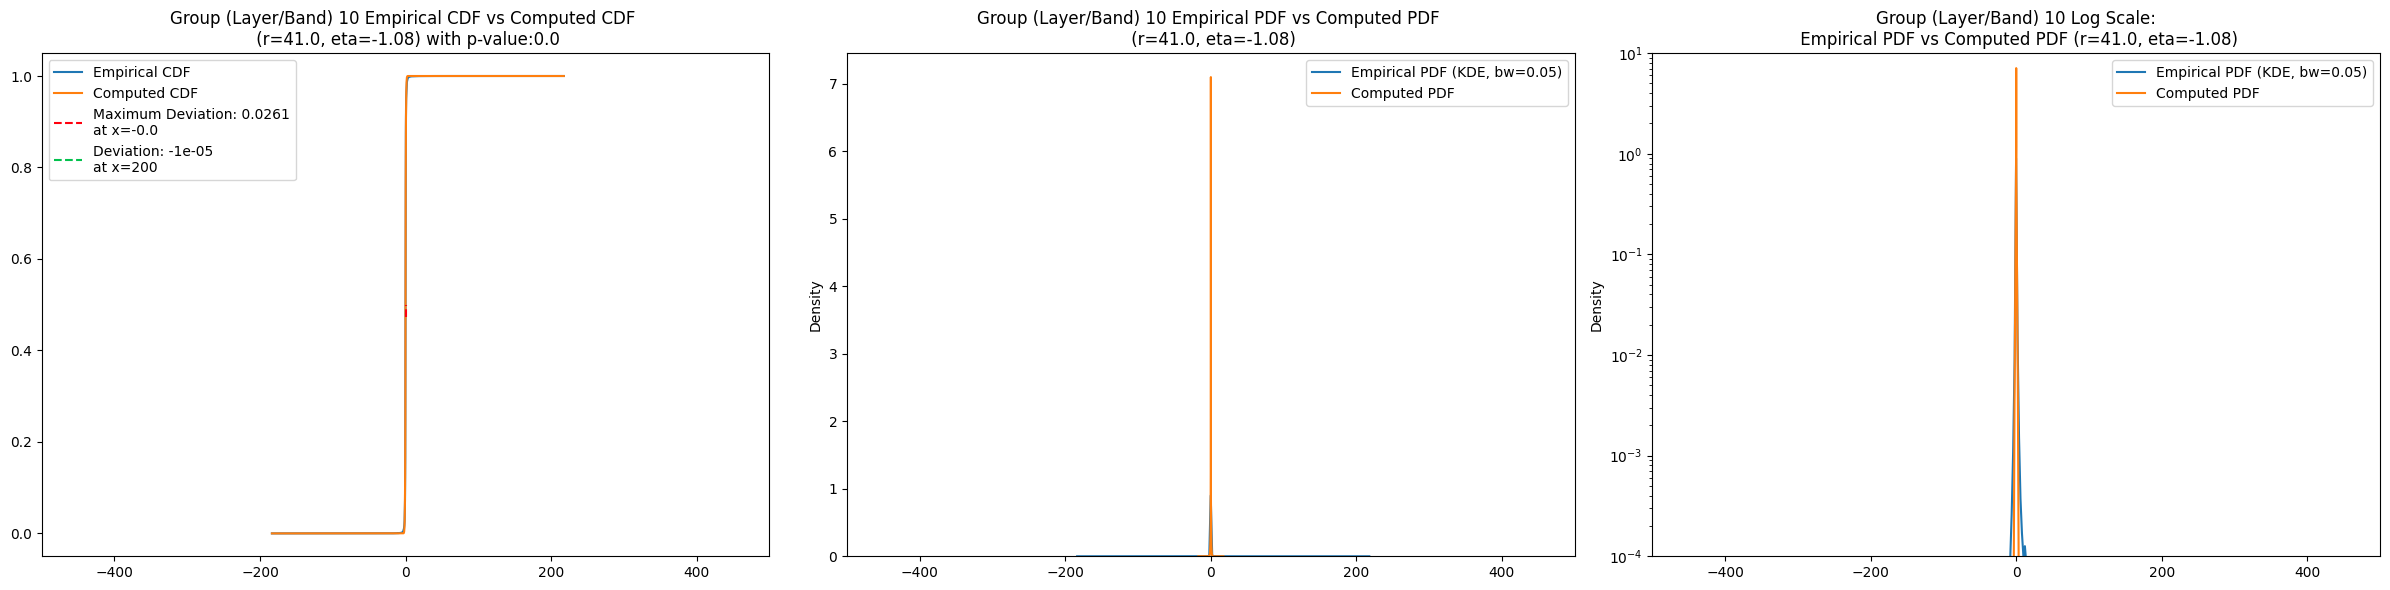

In [13]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-500, 500),
                    provided_loc=200)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [14]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [15]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0,0.22,0.4,0.017674,...,131.899000,0.055415,1.834910e-24,116.308000,0.029473,3.166700e-07,93.613400,0.026207,8.390310e-06,4.472656e-02
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0,0.23,0.0,0.016221,...,53.584400,0.057770,7.115700e-105,47.514500,0.031681,7.939590e-32,37.265100,0.030362,2.889150e-29,1.696509e-06
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0,0.26,-0.1,0.013363,...,23.148600,0.054251,0.000000e+00,20.677300,0.028975,1.831090e-105,16.103000,0.024964,2.153860e-78,2.120934e-17
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0,0.29,-0.3,0.010661,...,10.882500,0.048652,0.000000e+00,9.712140,0.023931,5.558780e-287,7.601830,0.018934,8.485670e-180,2.772210e-37
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0,0.34,-0.3,0.006480,...,5.731200,0.042154,0.000000e+00,5.101670,0.017177,0.000000e+00,4.012160,0.013458,0.000000e+00,4.519045e-80
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0,0.43,-0.2,0.006646,...,3.212460,0.039117,0.000000e+00,2.846970,0.013100,0.000000e+00,2.265980,0.012420,0.000000e+00,2.210606e-268
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0,0.45,-0.5,0.005162,...,2.081460,0.041292,0.000000e+00,1.837490,0.014487,0.000000e+00,1.467140,0.014351,0.000000e+00,0.000000e+00
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0,0.59,-0.7,0.006635,...,1.034170,0.043593,0.000000e+00,0.914581,0.017191,0.000000e+00,0.725643,0.015611,0.000000e+00,0.000000e+00
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0,49.00,-1.1,0.029237,...,0.361632,0.046655,0.000000e+00,0.298702,0.026100,0.000000e+00,0.237466,0.026100,0.000000e+00,0.000000e+00


In [16]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [17]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [18]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,188570.730000,99638.347266,330262.205781,536.032943,113.304539,760.943518,9000.0,0.22,0.4,0.017674,...,131.899000,0.055415,1.834910e-24,116.308000,0.029473,3.166700e-07,93.613400,0.026207,8.390310e-06,4.472656e-02
3,42568.312000,23773.759023,71607.318164,488.995293,135.974516,891.273099,36000.0,0.23,0.0,0.016221,...,53.584400,0.057770,7.115700e-105,47.514500,0.031681,7.939590e-32,37.265100,0.030362,2.889150e-29,1.696509e-06
4,10773.336000,5322.669939,20877.789746,785.242787,131.392261,1768.952665,144000.0,0.26,-0.1,0.013363,...,23.148600,0.054251,0.000000e+00,20.677300,0.028975,1.831090e-105,16.103000,0.024964,2.153860e-78,2.120934e-17
5,1800.434900,923.853034,3624.651760,858.037432,109.913749,2074.878934,576000.0,0.29,-0.3,0.010661,...,10.882500,0.048652,0.000000e+00,9.712140,0.023931,5.558780e-287,7.601830,0.018934,8.485670e-180,2.772210e-37
6,390.887500,183.288649,971.469804,1521.539632,104.035529,3444.523893,2304000.0,0.34,-0.3,0.006480,...,5.731200,0.042154,0.000000e+00,5.101670,0.017177,0.000000e+00,4.012160,0.013458,0.000000e+00,4.519045e-80
7,98.479220,41.024357,351.603812,3306.704964,84.348867,5672.120160,9216000.0,0.43,-0.2,0.006646,...,3.212460,0.039117,0.000000e+00,2.846970,0.013100,0.000000e+00,2.265980,0.012420,0.000000e+00,2.210606e-268
8,33.173733,15.926921,100.374029,2264.614116,78.321761,4638.636881,36864000.0,0.45,-0.5,0.005162,...,2.081460,0.041292,0.000000e+00,1.837490,0.014487,0.000000e+00,1.467140,0.014351,0.000000e+00,0.000000e+00
9,11.252635,4.427865,43.877700,5137.098532,82.329866,6105.371534,147456000.0,0.59,-0.7,0.006635,...,1.034170,0.043593,0.000000e+00,0.914581,0.017191,0.000000e+00,0.725643,0.015611,0.000000e+00,0.000000e+00
10,1.875914,0.615992,10.184802,9775.981567,78.684251,7496.855320,589824000.0,49.00,-1.1,0.029237,...,0.361632,0.046655,0.000000e+00,0.298702,0.026100,0.000000e+00,0.237466,0.026100,0.000000e+00,0.000000e+00
